In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import xarray as xr
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
import scipy.stats as stats
import regionmask
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import geopandas as gp
from shapely.geometry import Polygon, MultiPolygon
import regionmask

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

from shapely.geometry import Polygon, MultiPolygon
import regionmask

from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
from scipy.ndimage import label, binary_dilation

# Setup

## Data

In [2]:
def load_seasonal_data(experiment,var,months='JFM'):
    if months == 'JFM':
        months_flag = '-JFM'
    else:
        months_flag = ''
    #dat = xr.open_dataarray(f'/glade/campaign/univ/ucla0061/mcb/postprocessed/{experiment}-{var}-quarterly{months_flag}.nc')
    dat = xr.open_dataarray(f'/glade/derecho/scratch/wkrantz/postprocessed/{experiment}-{var}-quarterly{months_flag}.nc')
    return dat

In [3]:
# convert linestsring to polygon

sample_file = xr.open_dataset('/glade/derecho/scratch/wkrantz/archive/derecho-som-spinup-2-b46/atm/hist/derecho-som-spinup-2-b46.cam.h0.0045-01-02-00000.nc')

sample_file = xr.open_dataset('/glade/derecho/scratch/wkrantz/archive/derecho-som-spinup-2-b46/atm/hist/derecho-som-spinup-2-b46.cam.h0.0045-01-02-00000.nc')
cs = gp.read_file('/glade/u/home/wkrantz/new_MCB_teleconnections/scenario-setup/gbr_shapefiles/3dgbr_geomorph/qld_gbrwha_cscz.shp')
cs['geometry'] = cs['geometry'].apply(lambda x: Polygon(x))
cs['geometry'] = cs['geometry'].apply(lambda x: x.buffer(-1))

gbr_mask = regionmask.mask_geopandas(cs, lon_or_obj=sample_file.lon, lat=sample_file.lat) + 1

## Plotting

In [4]:

plt.rcParams['axes.facecolor'] = 'white'

class GeographicBounds(object):
    def __init__(self, lonMin, lonMax, latMin, latMax):
        self.lonMin = lonMin
        self.lonMax = lonMax
        self.latMin = latMin
        self.latMax = latMax

def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('')



# make colormaps
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    """
    Truncate a colormap to only use a subset of its range.
    
    Parameters:
    - cmap: The original colormap to truncate.
    - minval: The minimum value of the colormap (between 0 and 1).
    - maxval: The maximum value of the colormap (between 0 and 1).
    - n: The number of points in the new colormap.
    
    Returns:
    - A new colormap that spans the specified range.
    """
    new_cmap = LinearSegmentedColormap.from_list(
        f'trunc({cmap.name},{minval:.2f},{maxval:.2f})',
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

def discrete_colormap(cmap, n_colors):
    """
    Create a discrete colormap with a fixed number of colors.
    
    Parameters:
    - cmap: The original colormap to discretize.
    - n_colors: The number of discrete colors.
    
    Returns:
    - A new colormap with n discrete colors.
    """
    colors = cmap(np.linspace(0, 1, n_colors))
    return LinearSegmentedColormap.from_list(f'discrete_{cmap.name}', colors, N=n_colors)


n_segments = 13
custom_RdBu = truncate_colormap(plt.get_cmap('RdBu_r'), minval=0.1, maxval=0.9)
discrete_RdBu = discrete_colormap(custom_RdBu, n_colors=n_segments)

custom_RdBu_r = truncate_colormap(plt.get_cmap('RdBu'), minval=0.1, maxval=0.9)

custom_BrBG = truncate_colormap(plt.get_cmap('BrBG'), minval=0.1, maxval=0.9)
discrete_BrBG = discrete_colormap(custom_BrBG, n_colors=n_segments)

custom_BrBG_r = truncate_colormap(plt.get_cmap('BrBG_r'), minval=0.1, maxval=0.9)

custom_PuOr_r = truncate_colormap(plt.get_cmap('PuOr_r'), minval=0.15, maxval=0.85)
discrete_PuOr_r = discrete_colormap(custom_PuOr_r, n_colors=n_segments)

custom_PuOr = truncate_colormap(plt.get_cmap('PuOr'), minval=0.15, maxval=0.85)
discrete_PuOr = discrete_colormap(custom_PuOr, n_colors=n_segments)

custom_PiYG = truncate_colormap(plt.get_cmap('PiYG_r'), minval=0.15, maxval=0.85)
discrete_PiYG = discrete_colormap(custom_PiYG, n_colors=n_segments)


## Stats Functions

In [5]:
def ttest_with_fdr(months_pert,months_control):
    tstat,pval = stats.ttest_ind(months_pert, months_control,axis=0,equal_var=True)
    #tstat,pval = stats.ttest_rel(months_pert, months_control)

    pvals = np.sort(pval.flatten())
    N = len(pvals)
    i = np.arange(1,N+1)
    a = 0.1
    below = pvals<(a*i/N)
    below_locs = np.where(below)[0]
    if len(below_locs)>0:
        max_below = np.max(below_locs)
        threshold = pvals[max_below]
    else:
        threshold = pvals[0]
    return pval,threshold
    
def ttest_with_ac_adjustment(control,pert):
    # the lag 1 autocorrelation of the control data
    rho = pd.Series(control).autocorr(lag=1)

    x = control#.values
    y = pert#.values
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    std_x = np.std(x, ddof=1)
    std_y = np.std(y, ddof=1)
    n_eff_x = len(x) * (1 - rho) / (1 + rho)
    n_eff_y = len(y) * (1 - rho) / (1 + rho)
    pooled_variance = (((n_eff_x - 1) * std_x**2) + ((n_eff_y - 1) * std_y**2)) / (n_eff_x + n_eff_y - 2)
    pooled_std = np.sqrt(pooled_variance)
    t_stat = (mean_x - mean_y) / (pooled_std * np.sqrt(1/n_eff_x + 1/n_eff_y))
    df = n_eff_x + n_eff_y - 2
    p_value = 2 * (1 - stats.t.cdf(np.abs(t_stat), df=df))

    return t_stat,p_value



## Map plots

In [7]:

def plot_seasonal_diffs_with_ttest(exp_pert,exp_control,var, vmin, vmax,axs, subfig,
                                    standardize=False,lev=False,
                                  domain='gbr',months='JFM',seasons=['JFM'],
                                   num_segments = 11,
                                  highlight_domain=None,):
    
    
    namedict= {'PRECT':'P','TS':'TS','SST':'SST','T':'T','PS':'PS','FLUT':'OLR','Z3':'Z','U':'U','V':'V','OMEGA':'$\omega$','SF':'Streamfunction','TREFHT':'T 2m'}
    labeldict={'PRECT':'mm/day','TS':'$^{\circ}$C','T':'$^{\circ}$C','SST':'$^{\circ}$C','TREFHT':'$^{\circ}$C',
              'PS':'hPa','FLUT':'W m$^{-2}$','Z3':'m','U':'m/s','V':'m/s','OMEGA':'Pa/s','SF':'$10^6$m$^2$s$^{-1}$'}
    
    levdict = {'14':'200 hPa','20':'500 hPa','25':'850 hPa'}
    grey = '#908085'

    
    pert_data = load_seasonal_data(exp_pert,var,months=months)
    control_data = load_seasonal_data(exp_control,var,months=months)

    cmap = custom_PiYG
    
    if lev:
        pert_data=pert_data.isel(lev=lev)
        control_data=control_data.isel(lev=lev)
    
    if var=='PRECT':
        pert_data = pert_data*24*24*60*1000
        control_data = control_data*24*24*60*1000
        cmap = custom_BrBG
        
    if var=='PS':
        pert_data = pert_data/100
        control_data=control_data/100
        cmap = custom_PuOr

    if var=='SF':
        pert_data = pert_data * 1e-6
        control_data = control_data * 1e-6
        cmap = custom_PuOr

    if var=='FLUT':
        cmap = custom_PuOr

    if var=='Z3':
        cmap = custom_PiYG

    if var=='SST':
        cmap = custom_RdBu
    if var=='TREFHT':
        cmap = custom_RdBu
    if var=='TS':
        cmap = custom_RdBu
        

    cmap = discrete_colormap(cmap, n_colors=num_segments)
    
    if months=='DJF':
        season_dict = {'DJF':12,'MAM':3,'JJA':6,'SON':9}
    elif months=='JFM':
        season_dict = {'JFM':1,'AMJ':4,'JAS':7,'OND':10}
        season_dict = {'JFM':1}
        
    seas_avg_diffs = []
    seas_sigmasks = []
    for season in season_dict:
        month = season_dict[season]
        months_pert = pert_data.sel(time=pert_data.time.dt.month==month)
        months_control = control_data.sel(time=control_data.time.dt.month==month)

        #tstat,pval = stats.ttest_ind(months_pert, months_control,equal_var=True)
        #p_fdr=p
        pval,p_fdr = ttest_with_fdr(months_pert, months_control)

        seas_avg_diff = (months_pert.mean(dim='time') - months_control.mean(dim='time'))
        if standardize:
            seas_avg_diff = seas_avg_diff/months_control.std(dim='time')

            
        pval_xr = xr.DataArray(pval, dims=seas_avg_diff.dims, coords=seas_avg_diff.coords)

        diff_sigmask = pval_xr.where(pval<=p_fdr)
        # pre-process the data to just zeros and ones
        diff_sigmask = diff_sigmask.fillna(0)
        diff_sigmask = xr.where(diff_sigmask > 0, 1, 0)

        
        seas_avg_diffs.append(seas_avg_diff)
        seas_sigmasks.append(diff_sigmask)



    
        
    #fig = plt.figure(figsize=(15,8))
    fig = subfig
    if domain =='global':
        figwidth=21
    elif domain=='gbr':
        figwidth=13
    else:
        figwidth=13
    # fig = plt.figure(figsize=(10,9), facecolor='white')
    proj = ccrs.PlateCarree(180)
    for i,season in enumerate(season_dict):
        ax = axs[i]
        #ax=plt.subplot(1,1,i+1,projection=proj)
        fill = seas_avg_diffs[i].plot(ax=ax,cmap=cmap,vmin=vmin,vmax=vmax,transform=ccrs.PlateCarree(),add_colorbar=False)
        cs = seas_sigmasks[i].plot.contourf(levels=[0.8,1.0],hatches=['','..'],colors='none',add_colorbar=False,transform=ccrs.PlateCarree(), ax=ax)#levels=[0,1],hatches=['xxx',''],alpha=.2)
        for i, collection in enumerate(cs.collections):
            collection.set_edgecolor('k')
            collection.set_linewidth(0)

        # fill in the land area with white
        if var == 'SST':
            ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='k', facecolor='white'))
        ax.coastlines()
        if domain=='global':
            pass
        elif domain == 'mostly_global':
            ax.set_extent((120,-90,-80,70), crs=proj)
        elif domain == 'gbr':
            #bounds = GeographicBounds(120,180,-50,10)
            bounds = GeographicBounds(-100,0,-60,30)
            ax.set_extent((bounds.lonMin, bounds.lonMax, bounds.latMin, bounds.latMax), crs=proj)
        else:
            bounds = domain
            ax.set_extent((bounds.lonMin, bounds.lonMax, bounds.latMin, bounds.latMax), crs=ccrs.PlateCarree())
        if highlight_domain:
            for domain in highlight_domain:
                #draw a rectangle around the specified geographic domain
                ax.add_patch(plt.Rectangle((domain.lonMin, domain.latMin),
                                           domain.lonMax-domain.lonMin,
                                           domain.latMax-domain.latMin,
                                           fill=None, lw=2, color='magenta',transform=ccrs.PlateCarree()))

        # shpfl = shpreader.Reader('/glade/u/home/wkrantz/new_MCB_teleconnections/scenario-setup/gbr_shapefiles/Great_Barrier_Reef_Marine_Park_Boundary.geojson')
        # for rec, geo in zip(shpfl.records(), shpfl.geometries()):
        #         ax.add_geometries([geo],
        #                         crs=ccrs.PlateCarree(),
        #                         facecolor='none',
        #                         edgecolor='magenta',
        #                         linewidth=1,
        #                         linestyle='--')

        # shpfl = shpreader.Reader('/glade/u/home/wkrantz/new_MCB_teleconnections/scenario-setup/gbr_shapefiles/3dgbr_geomorph/qld_gbrwha_cscz.shp')
        # for rec, geo in zip(shpfl.records(), shpfl.geometries()):
        #         ax.add_geometries([geo],
        #                         crs=ccrs.PlateCarree(),
        #                         facecolor='none',
        #                         edgecolor='magenta',
        #                         linewidth=2,
        #                         linestyle='-')
            
        #ax.gridlines(draw_labels=True)
        #plt.colorbar(fill, orientation='horizontal')

        # plt.title(season)
               
    #### COLORBAR #####

    fig.subplots_adjust(bottom=0.1)
    cbar_ax = fig.add_axes([0.15, 0.04, 0.7, 0.03])
    if standardize:
        label_units = "$\sigma$"
    else:
        label_units = labeldict[var]
    
    cbar = fig.colorbar(fill, cax=cbar_ax, label=label_units, extend='both', orientation='horizontal')

    ticks = np.linspace(vmin, vmax, int(num_segments + 1 ))
    cbar.set_ticks(ticks)

    # Define the labels for the colorbar
    labels = [f'{tick:.1f}' for tick in ticks]
    cbar.set_ticklabels(labels)



    
    title = '$\Delta$' + namedict[var]
    if standardize:
        title = title + "/$\sigma$" + namedict[var]
        
    if lev:
        title = title + ' ' +levdict[str(lev)]


    if '40' in exp_pert:
        forcing_str = '40 W m$^{-2}$'
        if 'DJF' in exp_pert:
            forcing_str = forcing_str + ' DJF'
    elif '20' in exp_pert:
        forcing_str = '20 W m$^{-2}$'
    elif '20' in exp_pert:
        forcing_str = '20 W m$^{-2}$'
    elif '60' in exp_pert:
        forcing_str = '60 W m$^{-2}$'

    title = title + ' - ' + forcing_str

    # make super title for the whole plot
    plt.suptitle(title)
    
    #plt.tight_layout()
    if standardize:
        std_str = 'std'
    else:
        std_str = ''
    saveloc = f'/glade/u/home/wkrantz/new_MCB_teleconnections/analysis/figures/seas_diff_{exp_pert}_{exp_control}_{var}_{domain}_{std_str}'

    #plt.savefig(saveloc+'.png',dpi=400,bbox_inches='tight')
    #plt.show()
    
    del pert_data
    del control_data
    del months_control
    del months_pert

## Seasonal Var violin plot

In [31]:
def seasonal_var_plot_legend(var, bounds, lmask=None, plot_seasons = ['JFM','AMJ','JAS','OND'],
                      adjust_for_autocorrelation=True, ax=False):
    namedict= {'PRECT':'Precipitation','TS':'TS','SST':'SST','T':'T','PS':'PS','FLUT':'OLR','Z3':'Z','U':'U','V':'V','OMEGA':'$\omega$','SF':'Streamfunction'}
    labeldict={'PRECT':'mm/day','TS':'$^{\circ}$C','T':'$^{\circ}$C','SST':'$^{\circ}$C',
              'PS':'hPa','FLUT':'W m$^{-2}$','Z3':'m','U':'m/s','V':'m/s','OMEGA':'Pa/s','SF':'$10^6$m$^2$s$^{-1}$'}
    season_dict = {'JFM':1,'AMJ':4,'JAS':7,'OND':10}
    
    pert_data_20= load_seasonal_data('derecho-som-anom-eez-20-all',var)
    pert_data_40= load_seasonal_data('derecho-som-anom-eez-40-all',var)
    #pert_data_40= load_seasonal_data('derecho-som-anom-eez-40-allplus',var)
    pert_data_60= load_seasonal_data('derecho-som-anom-eez-60-all',var)
    pert_data_40DJF = load_seasonal_data('derecho-som-anom-eez-40DJF-all',var)
    #control_data = load_seasonal_data('derecho-som-control-qdpnoise1_2_control-all',var)
    control_data = load_seasonal_data('derecho-som-control-qdpnoise1_2_3-all',var)

    landmask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(control_data.lon,control_data.lat,wrap_lon=True)


    vals=[]
    datasets = [control_data, pert_data_40DJF, pert_data_20, pert_data_40, pert_data_60]
    ks_test_results = ['k','k','k','k','k']*len(plot_seasons)
    t_test_results = ['k','k','k','k','k']*len(plot_seasons)
    #impacts_df = pd.Dataframe()
    for i, season in enumerate(plot_seasons):
        
        for  ds in  datasets:
            month = season_dict[season]
            months = ds.sel(time=ds.time.dt.month==month)
            if var=='PRECT':
                months = months*86400*1000
            elif var=='SST':
                months = months-273.15
            elif var=='TS':
                months = months-273.15

            if lmask=='land':
                months = months.where(landmask==0, drop=True)
            elif lmask=='ocean':
                months = months.where(landmask!=0, drop=True)
                
            if bounds== 'gbr':
                roi = (months * gbr_mask).mean(['lat','lon'])
            else:
                roi = months.sel(lat=slice(bounds.latMin,bounds.latMax), lon=slice(bounds.lonMin,bounds.lonMax)).mean(['lat','lon'])
            
            
            vals.append(roi.values)
        
        for j in [1,2,3,4]:
            #ks_test = stats.ks_2samp(vals[len(datasets)*i+0],vals[len(datasets)*i+j])[1]
            control_data = vals[len(datasets)*i+0]
            pert_data = vals[len(datasets)*i+j]
            
            if adjust_for_autocorrelation:
                t_test = ttest_with_ac_adjustment(control_data,pert_data)[1]
            else:
                t_test = stats.ttest_ind(control_data,pert_data)[1]
            ks_test = stats.ks_2samp(control_data - np.mean(control_data),pert_data - np.mean(pert_data))[1]

            if t_test<0.05:
                t_test_results[len(datasets)*i+j] = 'w'
            if ks_test<0.05:
                ks_test_results[len(datasets)*i+j] = 'w'
                print(ks_test)
    
    if not ax:
        ax = plt.gca()
        plt.figure(figsize=(3.6*len(plot_seasons),5), facecolor='white')
        plt.figure(figsize=(5,5), facecolor='white')
        
    #purple that goes with '#74a9cf','#2b8cbe','#045a8d' is '#54278f'
    colors = ['k','#64379f','#74a9cf','#2b8cbe','#045a8d']
    alphas = [0.3,0.7, .9,.9,.9]
    locs = [1,2,3,4,5,
            9,10,11,12,13,
            17,18,19,20,21,
        25,26,27,28,29]
    gap = 0.2
    locs = [1,2+gap,3+2*gap,4+2*gap,5+2*gap,
            9,10+gap,11+2*gap,12+2*gap,13+2*gap,
            17,18+gap,19+2*gap,20+2*gap,21+2*gap,
            25,26+gap,27+2*gap,28+2*gap,29+2*gap]


    #adjust locs depending on number of seasons
    locs = locs[0:5*len(plot_seasons)]
    parts = ax.violinplot(vals,  locs, showmeans=True,widths=.8,)

    for i,pc in enumerate(parts['bodies']):
        j  = i%5
        pc.set_facecolor(colors[j])
        pc.set_alpha(alphas[j])
        #pc.set_edgecolor('black')

    for partname in ('cbars','cmins','cmaxes','cmeans'):
        vp = parts[partname]
        vp.set_edgecolor('k')
        vp.set_linewidth(0)




    means = [np.mean(val) for val in vals]
    quantile1 = [np.percentile(val,25) for val in vals]
    quantile3 = [np.percentile(val,75) for val in vals]
    stdevs = [np.std(val) for val in vals]

    ax.vlines(locs, quantile1, quantile3, color=ks_test_results, linestyle='-', lw=2)
    ax.scatter(locs, means, c=t_test_results, zorder=3, linewidth=1, edgecolor='k', s=30)


    ax.set_ylabel(f'{namedict[var]} ({labeldict[var]})')


    labels = ['','','JFM','','','','','','','',''
            'AMJ','','','','','','','',
            'JAS','','','','','','','',''
            'OND','','','',]

    labels = ['', '']
    for season in plot_seasons:
        labels.append(season)
        # add eight empty strings
        labels.extend(['']*7)
    labels = labels[:-4]
    set_axis_style(ax, labels)
    # add a legend
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color='k', lw=10, alpha=0.3), 
                    Line2D([0], [0], color='#64379f', lw=10, alpha=0.7),
                    Line2D([0], [0], color='#74a9cf', lw=10, alpha=0.9),
                    Line2D([0], [0], color='#2b8cbe', lw=10, alpha=0.9),
                    Line2D([0], [0], color='#045a8d', lw=10, alpha=0.9),]

    # legend box with non-bold text, outside of plot

    if len(plot_seasons)==2:
        spacing = 1.6
    else:
        spacing = 1.3
    #ax.legend(custom_lines, ['Control', '40 W/m2 DJF', '20 W/m2', '40 W/m2', '60 W/m2'], loc='upper right', prop={'weight': 'normal'}, bbox_to_anchor=(spacing, 1), )
    #1.8
    ax.legend(custom_lines, ['Control', '40 W m$^{-2}$ DJF', '20 W m$^{-2}$', '40 W m$^{-2}$', '60 W m$^{-2}$'], loc='upper right', prop={'weight': 'normal'}, bbox_to_anchor=(1.25, 1), )
    

    # make the background white
    ax.set_facecolor('white')

In [15]:
# def seasonal_var_plot(var, bounds,name='', lmask=None, plot_seasons = ['JFM','AMJ','JAS','OND'],
#                       adjust_for_autocorrelation=True, ax=False):
#     namedict= {'PRECT':'P','TS':'TS','SST':'SST','T':'T','PS':'PS','FLUT':'OLR','Z3':'Z','U':'U','V':'V','OMEGA':'$\omega$','SF':'Streamfunction'}
#     labeldict={'PRECT':'mm/day','TS':'$^{\circ}$C','T':'$^{\circ}$C','SST':'$^{\circ}$C',
#               'PS':'hPa','FLUT':'W m$^{-2}$','Z3':'m','U':'m/s','V':'m/s','OMEGA':'Pa/s','SF':'$10^6$m$^2$s$^{-1}$'}
#     season_dict = {'JFM':1,'AMJ':4,'JAS':7,'OND':10}
    
#     pert_data_20= load_seasonal_data('derecho-som-anom-eez-20-all',var)
#     pert_data_40= load_seasonal_data('derecho-som-anom-eez-40-all',var)
#     #pert_data_40= load_seasonal_data('derecho-som-anom-eez-40-allplus',var)
#     pert_data_60= load_seasonal_data('derecho-som-anom-eez-60-all',var)
#     pert_data_40DJF = load_seasonal_data('derecho-som-anom-eez-40DJF-all',var)
#     #control_data = load_seasonal_data('derecho-som-control-qdpnoise1_2_control-all',var)
#     control_data = load_seasonal_data('derecho-som-control-qdpnoise1_2_3-all',var)

#     landmask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(control_data.lon,control_data.lat,wrap_lon=True)


#     vals=[]
#     datasets = [control_data, pert_data_40DJF, pert_data_20, pert_data_40, pert_data_60]
#     ks_test_results = ['k','k','k','k','k']*len(plot_seasons)
#     t_test_results = ['k','k','k','k','k']*len(plot_seasons)
#     #impacts_df = pd.Dataframe()
#     for i, season in enumerate(plot_seasons):
        
#         for  ds in  datasets:
#             month = season_dict[season]
#             months = ds.sel(time=ds.time.dt.month==month)
#             if var=='PRECT':
#                 months = months*86400*1000
#             elif var=='SST':
#                 months = months-273.15
#             elif var=='TS':
#                 months = months-273.15

#             if lmask=='land':
#                 months = months.where(landmask==0, drop=True)
#             elif lmask=='ocean':
#                 months = months.where(landmask!=0, drop=True)
                
#             if bounds== 'gbr':
#                 roi = (months * gbr_mask).mean(['lat','lon'])
#             else:
#                 roi = months.sel(lat=slice(bounds.latMin,bounds.latMax), lon=slice(bounds.lonMin,bounds.lonMax)).mean(['lat','lon'])
            
            
#             vals.append(roi.values)
        
#         for j in [1,2,3,4]:
#             #ks_test = stats.ks_2samp(vals[len(datasets)*i+0],vals[len(datasets)*i+j])[1]
#             control_data = vals[len(datasets)*i+0]
#             pert_data = vals[len(datasets)*i+j]
            
#             if adjust_for_autocorrelation:
#                 t_test = ttest_with_ac_adjustment(control_data,pert_data)[1]
#             else:
#                 t_test = stats.ttest_ind(control_data,pert_data)[1]
#             ks_test = stats.ks_2samp(control_data - np.mean(control_data),pert_data - np.mean(pert_data))[1]

#             if t_test<0.05:
#                 t_test_results[len(datasets)*i+j] = 'w'
#             if ks_test<0.05:
#                 ks_test_results[len(datasets)*i+j] = 'w'
#                 print(ks_test)
    
#     if not ax:
#         ax = plt.gca()
#         plt.figure(figsize=(3.6*len(plot_seasons),5), facecolor='white')
#         plt.figure(figsize=(5,5), facecolor='white')
        
#     #purple that goes with '#74a9cf','#2b8cbe','#045a8d' is '#54278f'
#     colors = ['k','#64379f','#74a9cf','#2b8cbe','#045a8d']
#     alphas = [0.3,0.7, .9,.9,.9]
#     locs = [1,2,3,4,5,
#             9,10,11,12,13,
#             17,18,19,20,21,
#         25,26,27,28,29]
#     gap = 0.2
#     locs = [1,2+gap,3+2*gap,4+2*gap,5+2*gap,
#             9,10+gap,11+2*gap,12+2*gap,13+2*gap,
#             17,18+gap,19+2*gap,20+2*gap,21+2*gap,
#             25,26+gap,27+2*gap,28+2*gap,29+2*gap]


#     #adjust locs depending on number of seasons
#     locs = locs[0:5*len(plot_seasons)]
#     parts = ax.violinplot(vals,  locs, showmeans=True,widths=.8,)

#     for i,pc in enumerate(parts['bodies']):
#         j  = i%5
#         pc.set_facecolor(colors[j])
#         pc.set_alpha(alphas[j])
#         #pc.set_edgecolor('black')

#     for partname in ('cbars','cmins','cmaxes','cmeans'):
#         vp = parts[partname]
#         vp.set_edgecolor('k')
#         vp.set_linewidth(0)




#     means = [np.mean(val) for val in vals]
#     quantile1 = [np.percentile(val,25) for val in vals]
#     quantile3 = [np.percentile(val,75) for val in vals]
#     stdevs = [np.std(val) for val in vals]

#     ax.vlines(locs, quantile1, quantile3, color=ks_test_results, linestyle='-', lw=2)
#     ax.scatter(locs, means, c=t_test_results, zorder=3, linewidth=1, edgecolor='k', s=30)


#     ax.set_ylabel(f'{namedict[var]} ({labeldict[var]})')


#     labels = ['','','JFM','','','','','','','',''
#             'AMJ','','','','','','','',
#             'JAS','','','','','','','',''
#             'OND','','','',]

#     labels = ['', '']
#     for season in plot_seasons:
#         labels.append(season)
#         # add eight empty strings
#         labels.extend(['']*7)
#     labels = labels[:-4]
#     #set_axis_style(ax, labels)
#     # set x ticks at locs but no labels
#     ax.set_xticks(locs)
#     ax.set_xticklabels('')

#     # make more space for the legend by expanding the range of the x-axis
#     #ax.set_xlim(0, 14)

#     # Add labels for each violin plot along the x-axis
#     labels = ['Control', '40 W m$^{-2}$ \nDJF', '20 W m$^{-2}$', '40 W m$^{-2}$', '60 W m$^{-2}$']
#     for i in range(len(plot_seasons)):
#         for j, label in enumerate(labels):
#             ax.text(locs[i*5 + j], ax.get_ylim()[0] - (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.05, label,
#                     ha='center', va='top', rotation=45, fontsize=globalfigurefontsize)

#     # make the background white
#     ax.set_facecolor('white')

In [9]:
# trying to plot stderr insted of min and max
def annual_var_plot(var, bounds, name='', lmask=None,
                    adjust_for_autocorrelation=True):
    namedict= {'PRECT':'P','TS':'TS','SST':'SST','T':'T','PS':'PS','FLUT':'OLR','Z3':'Z','U':'U','V':'V','OMEGA':'$\omega$','SF':'Streamfunction'}
    labeldict={'PRECT':'mm/day','TS':'$^{\circ}$C','T':'$^{\circ}$C','SST':'$^{\circ}$C',
              'PS':'hPa','FLUT':'W m$^{-2}$','Z3':'m','U':'m/s','V':'m/s','OMEGA':'Pa/s','SF':'$10^6$m$^2$s$^{-1}$'}
    season_dict = {'JFM':1,'AMJ':4,'JAS':7,'OND':10}
    
    pert_data_20= load_seasonal_data('derecho-som-anom-eez-20-all',var)
    pert_data_40= load_seasonal_data('derecho-som-anom-eez-40-all',var)
    #pert_data_40= load_seasonal_data('derecho-som-anom-eez-40-allplus',var)
    pert_data_60= load_seasonal_data('derecho-som-anom-eez-60-all',var)
    pert_data_40DJF = load_seasonal_data('derecho-som-anom-eez-40DJF-all',var)
    #control_data = load_seasonal_data('derecho-som-control-qdpnoise1_2_control-all',var)
    control_data = load_seasonal_data('derecho-som-control-qdpnoise1_2_3-all',var)

    landmask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(control_data.lon,control_data.lat,wrap_lon=True)

    vals=[]
    datasets = [ control_data, pert_data_40DJF,pert_data_20, pert_data_40, pert_data_60]
    #impacts_df = pd.Dataframe()

    for  ds in  datasets:
        months = ds.groupby('time.year').mean()
        if var=='PRECT':
            months = months*86400*1000
        elif var=='SST':
            months = months-273.15
        elif var=='TS':
            months = months-273.15

        if lmask=='land':
            months = months.where(landmask==0, drop=True)
        elif lmask=='ocean':
            months = months.where(landmask!=0, drop=True)
                

            
        if bounds== 'gbr':
            roi = (months * gbr_mask).mean(['lat','lon'])
        else:
            roi = months.sel(lat=slice(bounds.latMin,bounds.latMax), lon=slice(bounds.lonMin,bounds.lonMax)).mean(['lat','lon'])
        vals.append(roi.values)


    # for each dataset in vals, perform a two-sample ks test to see if the distributions are different from the control simulation 

    ks_test_results = ['k','k','k','k','k']
    t_test_results = ['k','k','k','k','k']

    for i in [1,2,3,4]:
            control_data = vals[0]
            pert_data = vals[i]
            if adjust_for_autocorrelation:
                t_test = ttest_with_ac_adjustment(control_data,pert_data)[1]
            else:
                t_test = stats.ttest_ind(control_data,pert_data)[1]
                
            ks_test = stats.ks_2samp(control_data - np.mean(control_data),pert_data - np.mean(pert_data))[1]

            if t_test<0.05:
                t_test_results[i] = 'w'
            if ks_test<0.05:
                ks_test_results[i] = 'w'

    plt.figure(figsize=(5,5), facecolor='white')

    #purple that goes with '#74a9cf','#2b8cbe','#045a8d' is '#54278f'
    colors = ['k','#64379f','#74a9cf','#2b8cbe','#045a8d']
    alphas = [0.3,0.7,.9,.9,.9]
    gap =0.2
    locs = [1,2+gap,3+2*gap,4+2*gap,5+2*gap]
    
    parts = plt.violinplot(vals,  locs, showmeans=True,widths=.8)

    for i,pc in enumerate(parts['bodies']):
        j  = i%5
        pc.set_facecolor(colors[j])
        pc.set_alpha(alphas[j])
        #pc.set_edgecolor('black')




    for partname in ('cbars','cmins','cmaxes','cmeans'):
        vp = parts[partname]
        vp.set_edgecolor('r')
        vp.set_linewidth(0)
    
    ax = plt.gca()
    vals = np.array(vals)
    # calculate the standard error for each dataset in vals
    stderrs = np.array([np.std(vals[i],axis=0)/np.sqrt(len(vals[i])) for i in range(len(vals))])
    stdevs = np.array([np.std(vals[i],axis=0) for i in range(len(vals))])
    means = np.array([np.mean(vals[i],axis=0) for i in range(len(vals))])
    # calculate the 25th and 75th percentiles
    quartile1 = [np.percentile(vals[i],25,axis=0) for i in range(len(vals))]
    quartile3 = [np.percentile(vals[i],75,axis=0) for i in range(len(vals))]


    ax.scatter(locs,means, c=t_test_results,s=100, zorder=8, marker='o', linewidths=1, edgecolors='k')
    #ax.vlines(locs,means-stderrs,means+stderrs, color='r', lw=3)
    #ax.vlines(locs,means-stdevs,means+stdevs, color='k', lw=4)
    ax.vlines(locs,quartile1,quartile3, color=ks_test_results, lw=4)

    plt.ylabel(f'{namedict[var]} ({labeldict[var]})')


    #labels = ['40-DJF','Control','20','40','60']
    

    #set_axis_style(ax, labels)
    #rotate the x axis labels
    #plt.xticks(rotation=45)
    
    # no x axis labels
    ax.set_xticks([])

    plt.title(name)


    # add a legend
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color='k', lw=10, alpha=0.3), 
                    Line2D([0], [0], color='#64379f', lw=10, alpha=0.7),
                    Line2D([0], [0], color='#74a9cf', lw=10, alpha=0.9),
                    Line2D([0], [0], color='#2b8cbe', lw=10, alpha=0.9),
                    Line2D([0], [0], color='#045a8d', lw=10, alpha=0.9),]

    # legend box with non-bold text, outside of plot
    ax.legend(custom_lines, ['Control', '40 \nW m$^{-2}$ DJF', '20 \nW m$^{-2}$', '40 \nW m$^{-2}$', '60 \nW m$^{-2}$'], loc='upper right', prop={'weight': 'normal'}, bbox_to_anchor=(1.8, 1), )

## Monthly cycle



In [10]:
def monthly_cycle_plot(ax):
    sample_file = xr.open_dataset('/glade/derecho/scratch/wkrantz/archive/derecho-som-spinup-2-b46/atm/hist/derecho-som-spinup-2-b46.cam.h0.0045-01-02-00000.nc')
    cs = gp.read_file('/glade/u/home/wkrantz/new_MCB_teleconnections/scenario-setup/gbr_shapefiles/3dgbr_geomorph/qld_gbrwha_cscz.shp')
    
    cs['geometry'] = cs['geometry'].apply(lambda x: Polygon(x))
    
    #apply an offset to the polygon to keep it within the region that was actually cooled
    cs['geometry'] = cs['geometry'].apply(lambda x: x.buffer(-1))
    
    gbr_mask = regionmask.mask_geopandas(cs, lon_or_obj=sample_file.lon, lat=sample_file.lat) + 1
    
    months = ['Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']
    
    var = 'SST'
    control = xr.open_dataset(f'/glade/derecho/scratch/wkrantz/postprocessed/derecho-som-control-qdpnoise1_2_control-all-{var}-monthly.nc')
    force20 = xr.open_dataset(f'/glade/derecho/scratch/wkrantz/postprocessed/derecho-som-anom-eez-20-all-{var}-monthly.nc')
    force40 = xr.open_dataset(f'/glade/derecho/scratch/wkrantz/postprocessed/derecho-som-anom-eez-40-all-{var}-monthly.nc')
    force60 = xr.open_dataset(f'/glade/derecho/scratch/wkrantz/postprocessed/derecho-som-anom-eez-60-all-{var}-monthly.nc')
    
    force40DJF = xr.open_dataset(f'/glade/derecho/scratch/wkrantz/postprocessed/derecho-som-anom-eez-40DJF-all-{var}-monthly.nc')
    plt.figure(figsize=(8,5), facecolor='white')
    
    colors = ['k','#2b8cbe','#64379f']
    alphas = [0.6,.9,.7]
    labels = ['Control','40 W m$^{-2}$','40 W m$^{-2}$ DJF']
    for i,ds in enumerate([control,force40,force40DJF]):
    
        mean = (ds['SST']*gbr_mask- 273.15).mean(dim=['lat','lon']).groupby('time.month').mean()
        std = (ds['SST']*gbr_mask- 273.15).mean(dim=['lat','lon']).groupby('time.month').std()
        mean = np.insert(mean.values[0:-1],0,mean.values[-1])  
        std = np.insert(std.values[0:-1],0,std.values[-1])
        ax.plot(months,mean, lw=4, alpha=alphas[i], color=colors[i], label=labels[i])
        ax.fill_between(months,mean-std,mean+std, alpha=0.1, color=colors[i])
    
        if i==0:
            control_max = max(mean)
            control_mean = np.mean(mean)
        else:
            print(max(mean) - control_max)
            print(np.mean(mean) - control_mean)
    
    
    # for ds in [force20,force60]:
    #     mean = (ds['SST']*gbr_mask).mean(dim=['lat','lon']).groupby('time.month').mean()
    #     mean = np.insert(mean.values[0:-1],0,mean.values[-1])
    #     plt.plot(months,mean, lw=1, alpha=0.6)

    # add a legend
    ax.set_ylabel('SST ($^\circ$C)')
    ax.legend(loc='upper right', fontsize=globalfigurefontsize)


# Multifigure Plots

In [11]:
globalfigurefontsize=12

def letter_annotation(ax, xoffset, yoffset, letter):
 # Add the letter annotation with z order to make sure it is on top of the plot
 ax.text(xoffset, yoffset, letter, transform=ax.transAxes,
         size=18, weight='bold', zorder=10)

font = {
        'weight' : 'regular',
        'size'   : 12}

plt.rc('font', **font)

## FIgure 1


-0.7169906836711952
-0.8016833173419222
-0.52412053795247
-0.12287720176573202


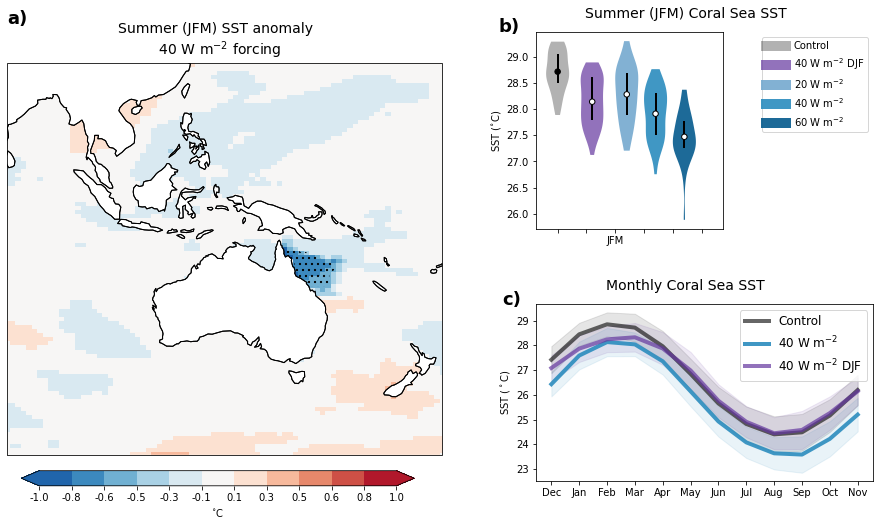

<Figure size 576x360 with 0 Axes>

In [12]:
title_fontfize = 14

# Create the main figure
fig = plt.figure(figsize=(13, 7))

# Create two subfigures side by side
leftfig, rightfig = fig.subfigures(1, 2, width_ratios=(3,2))

# Set background color and titles for the subfigures
leftfig.set_facecolor('#ffffff')
leftfig.suptitle('Summer (JFM) SST anomaly \n 40 W m$^{-2}$ forcing', fontsize= title_fontfize, y=0.96)

rightfig.set_facecolor('#ffffff')
topright, bottomright = rightfig.subfigures(2, 1, height_ratios=(1, 1))
topright.suptitle('Summer (JFM) Coral Sea SST', fontsize= title_fontfize)
bottomright.suptitle('Monthly Coral Sea SST', fontsize= title_fontfize, y=0.9)

# Create geographic axes for the left figure (use PlateCarree projection)
left_axs = leftfig.add_subplot(111, projection=ccrs.PlateCarree())

# Create standard axes for the right subfigures
# make the top right axis narrower
topright_axs = topright.subplots(1, 1)


bottomright_axs = bottomright.subplots(1, 1)

# # Example plot functions (Assuming they are defined elsewhere)
# # Plotting monthly cycle in bottomright_axs

# Plotting a seasonal difference map in left_axs with the specified projection
letter_annotation(left_axs, 0, 1.1, 'a)')
#add a title to the left axis
#left_axs.set_title('Summer (JFM) SST anomaly \n 40 W m$^{-2}$ forcing', fontsize= title_fontfize)
plot_seasonal_diffs_with_ttest('derecho-som-anom-eez-40DJF-all','derecho-som-control-qdpnoise1_2_3-all','SST',vmin=-1,vmax=1,standardize=False,lev=False,
                               highlight_domain=None, months='JFM', domain='gbr', axs=[left_axs], subfig = leftfig)



letter_annotation(topright_axs,-0.2, 1, 'b)')

seasonal_var_plot_legend('SST', 'gbr',plot_seasons=['JFM'], ax = topright_axs)


letter_annotation(bottomright_axs, -0.1,1, 'c)')

monthly_cycle_plot(bottomright_axs)


# Spacing between the subfigures
topright.subplots_adjust(hspace=0.8, wspace=0.4, left=0.1, right=0.6)

bottomright.subplots_adjust(bottom=.1, top=0.8, left=0.1, right=1)

fig.savefig('/glade/u/home/wkrantz/new_MCB_teleconnections/figures/pub_figures/figure1.png', dpi=400, bbox_inches='tight')

plt.show()


# Figure 2

## Zonal plotting

In [13]:
import matplotlib.ticker as mticker
from matplotlib.ticker import LogLocator, FixedLocator

def plot_seasonal_diffs_with_ttest_zonal(exp_pert,exp_control,var, vmin, vmax, ax = False,
                                    standardize=False,lev=False,
                                  domain='gbr',months='JFM',
                                   num_segments = 11):

    namedict= {'PRECT':'P','TS':'TS','SST':'SST','T':'T','PS':'PS','FLUT':'OLR','Z3':'Z','U':'U','V':'V','OMEGA':'$\omega$','SF':'Streamfunction'}
    labeldict={'PRECT':'mm/day','TS':'$^{\circ}$C','T':'$^{\circ}$C','SST':'$^{\circ}$C',
              'PS':'hPa','FLUT':'W/m$^2$','Z3':'m','U':'m/s','V':'m/s','OMEGA':'Pa/s','SF':'$10^6$m$^2$s$^{-1}$'}
    
    levdict = {'14':'200 hPa','20':'500 hPa','25':'850 hPa'}
    grey = '#908085'

    
    pert_data = load_seasonal_data(exp_pert,var,months=months)
    control_data = load_seasonal_data(exp_control,var,months=months)

    pert_data=pert_data.sel(lev=slice(120,1000), lon=slice(145,151)).mean(['lon'])
    control_data=control_data.sel(lev=slice(120,1000),lon=slice(145,151)).mean(['lon'])

    cmap = custom_RdBu_r
    
    if lev:
        pert_data=pert_data.isel(lev=lev)
        control_data=control_data.isel(lev=lev)
    
    if var=='PRECT':
        pert_data = pert_data*24*24*60*1000
        control_data = control_data*24*24*60*1000
        cmap = custom_BrBG
        
    if var=='PS':
        pert_data = pert_data/100
        control_data=control_data/100
        cmap = custom_PuOr

    if var=='SF':
        pert_data = pert_data * 1e-6
        control_data = control_data * 1e-6
        cmap = custom_PuOr

    if var=='FLUT':
        cmap = custom_PuOr

    if var=='Z3':
        cmap = custom_PiYG

    if var=='SST':
        cmap = custom_RdBu
        

    cmap = discrete_colormap(cmap, n_colors=num_segments)
    
    if months=='DJF':
        season_dict = {'DJF':12,'MAM':3,'JJA':6,'SON':9}
    elif months=='JFM':
        season_dict = {'JFM':1}#,'AMJ':4,'JAS':7,'OND':10}
        
    seas_avg_diffs = []
    seas_sigmasks = []
    for season in season_dict:
        month = season_dict[season]
        months_pert = pert_data.sel(time=pert_data.time.dt.month==month)
        months_control = control_data.sel(time=control_data.time.dt.month==month)

        #tstat,pval = stats.ttest_ind(months_pert, months_control,equal_var=True)
        #p_fdr=p
        pval,p_fdr = ttest_with_fdr(months_pert, months_control)

        seas_avg_diff = (months_pert.mean(dim='time') - months_control.mean(dim='time'))
        if standardize:
            seas_avg_diff = seas_avg_diff/months_control.std(dim='time')

            
        pval_xr = xr.DataArray(pval, dims=seas_avg_diff.dims, coords=seas_avg_diff.coords)

        diff_sigmask = pval_xr.where(pval<=p_fdr)
        # pre-process the data to just zeros and ones
        diff_sigmask = diff_sigmask.fillna(0)
        diff_sigmask = xr.where(diff_sigmask > 0, 1, 0)
        
        seas_avg_diffs.append(seas_avg_diff)
        seas_sigmasks.append(diff_sigmask)
    
        

    if not ax:
        fig = plt.figure(figsize=(10,8), facecolor='white')

    for i,season in enumerate(season_dict):
        if not ax:
            ax=plt.subplot(1,1,i+1)
        fill = seas_avg_diffs[i].plot(ax=ax,cmap=cmap,vmin=vmin,vmax=vmax,add_colorbar=False)
        cs = seas_sigmasks[i].plot.contourf(ax=ax,levels=[0.8,1.0],hatches=['','..'],colors='none',add_colorbar=False)#levels=[0,1],hatches=['xxx',''],alpha=.2)
        for i, collection in enumerate(cs.collections):
            collection.set_edgecolor('k')
            collection.set_linewidth(0)

        #plt.title(season)
        ax.invert_yaxis()
        ax.set_ylabel('Pressure (hPa)')
        ax.set_xlabel('Latitude')
        ax.set_yscale('log')
        #ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())
        #ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
        #ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))

               
    #fig.subplots_adjust(right=0.9)
    #cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    
    # if standardize:
    #     label_units = "$\sigma$"
    # else:
    #     label_units = labeldict[var]
    
    # cbar = fig.colorbar(fill, cax=cbar_ax,label=label_units, extend='both')

    # ticks = np.linspace(vmin, vmax, num_segments + 1)
    # cbar.set_ticks(ticks)

    # # Define the labels for the colorbar
    # labels = [f'{tick:.1f}' for tick in ticks]
    # cbar.set_ticklabels(labels)

    # title = '$\Delta$' + namedict[var]
    # if standardize:
    #     title = title + "/$\sigma$" + namedict[var]
        
    # if lev:
    #     title = title + ' ' +levdict[str(lev)]

    # if '40' in exp_pert:
    #     forcing_str = '40 W/m$^2$'
    #     if 'DJF' in exp_pert:
    #         forcing_str = forcing_str + ' DJF'
    # elif '20' in exp_pert:
    #     forcing_str = '20 W/m$^2$'
    # elif '20' in exp_pert:
    #     forcing_str = '20 W/m$^2$'
    # elif '60' in exp_pert:
    #     forcing_str = '60 W/m$^2$'

    # title = title + ' - ' + forcing_str

    # # make super title for the whole plot
    # plt.suptitle(title)
    
    # #plt.tight_layout()
    # if standardize:
    #     std_str = 'std'
    # else:
        std_str = ''
    #saveloc = f'/glade/u/home/wkrantz/new_MCB_teleconnections/analysis/figures/seas_diff_{exp_pert}_{exp_control}_{var}_{domain}_{std_str}'

    #plt.savefig(saveloc+'.png',dpi=400,bbox_inches='tight')
    #plt.show()
    
    del pert_data
    del control_data
    del months_control
    del months_pert
    return fill

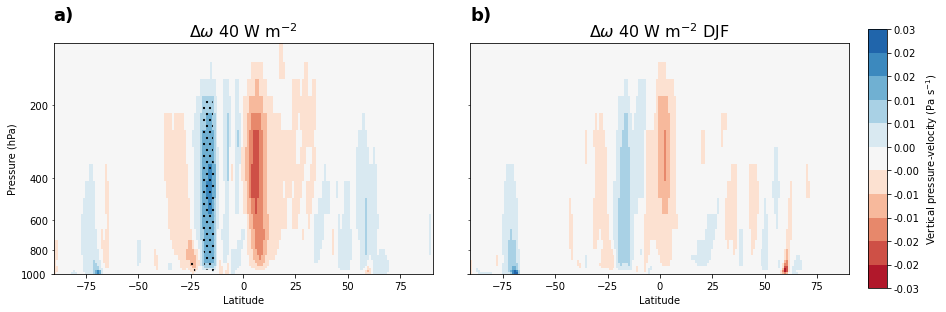

In [14]:
from matplotlib.ticker import ScalarFormatter, FixedLocator, FormatStrFormatter
import matplotlib as mpl
title_fontfize = 14

font = {
        'weight' : 'regular',
        'size'   : 12}

# Create the main figure
fig = plt.figure(figsize=(13, 4))

# Create two subfigures side by side

(left, right) = fig.subplots(1,2,)
#control = 'derecho-som-control-qdpnoise1_2_control-all'
control = 'derecho-som-control-qdpnoise1_2_3-all'

pert = 'derecho-som-anom-eez-40-all'
cs = plot_seasonal_diffs_with_ttest_zonal(pert,control,'OMEGA',-0.03,0.03,standardize=False, ax=left)
left.set_title('$\Delta \omega$ 40 W m$^{-2}$', fontsize=16)
#left.set_yticklabels([1000, 800, 500, 100], minor=False)

left.yaxis.set_minor_formatter(ScalarFormatter())
left.yaxis.set_major_formatter(ScalarFormatter())
minor_ticks = [200, 400, 600, 800]
left.yaxis.set_minor_locator(FixedLocator(minor_ticks))
left.set_yticklabels(minor_ticks, minor=True)

control = 'derecho-som-control-qdpnoise1_2_3-all'
pert = 'derecho-som-anom-eez-40DJF-all'
cs = plot_seasonal_diffs_with_ttest_zonal(pert,control,'OMEGA', -0.03,0.03,standardize=False, ax = right)
right.set_title('$\Delta \omega$ 40 W m$^{-2}$ DJF', fontsize=16)


right.yaxis.set_minor_locator(FixedLocator(minor_ticks))

right.set_yticklabels([], minor=True)
right.set_yticklabels([], minor=False)
right.set_ylabel('')


# Specify positions for the minor y-ticks

# Specify labels for the minor y-ticks


fig.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1, wspace=0.1)

#colorbar

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.05, 0.02, 0.9])  # [left, bottom, width, height]
cbar = fig.colorbar(cs, cax=cbar_ax, label="Vertical pressure-velocity (Pa s$^{-1}$)")
num_segments=11
vmin=-0.03
vmax=0.03
ticks = np.linspace(vmin, vmax, int(num_segments + 1 ))
cbar.set_ticks(ticks)

# Define the labels for the colorbar
labels = [f'{tick:.1f}' for tick in ticks]
cbar.set_ticklabels(labels)
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # Change '2' to your desired number of decimal places

letter_annotation(left, 0, 1.1, 'a)')
letter_annotation(right, 0, 1.1, 'b)')


fig.savefig('/glade/u/home/wkrantz/new_MCB_teleconnections/figures/pub_figures/figure2.png', dpi=400, bbox_inches='tight')

plt.show()



## Figure 3

In [15]:

def plot_seasonal_diffs_with_ttest(exp_pert,exp_control,var, vmin, vmax,axs,
                                    standardize=False,lev=False,
                                  domain='gbr',months='JFM',
                                   num_segments = 11,
                                  highlight_domain=None,):
    
    
    namedict= {'PRECT':'P','TS':'TS','SST':'SST','T':'T','PS':'PS','FLUT':'OLR','Z3':'Z','U':'U','V':'V','OMEGA':'$\omega$','SF':'Streamfunction','TREFHT':'T 2m'}
    labeldict={'PRECT':'mm/day','TS':'$^{\circ}$C','T':'$^{\circ}$C','SST':'$^{\circ}$C','TREFHT':'$^{\circ}$C',
              'PS':'hPa','FLUT':'W m$^{-2}$','Z3':'m','U':'m/s','V':'m/s','OMEGA':'Pa/s','SF':'$10^6$m$^2$s$^{-1}$'}
    
    levdict = {'14':'200 hPa','20':'500 hPa','25':'850 hPa'}
    grey = '#908085'

    
    pert_data = load_seasonal_data(exp_pert,var,months=months)
    control_data = load_seasonal_data(exp_control,var,months=months)

    cmap = custom_PiYG
    
    if lev:
        pert_data=pert_data.isel(lev=lev)
        control_data=control_data.isel(lev=lev)
    
    if var=='PRECT':
        pert_data = pert_data*24*24*60*1000
        control_data = control_data*24*24*60*1000
        cmap = custom_BrBG
        
    if var=='PS':
        pert_data = pert_data/100
        control_data=control_data/100
        cmap = custom_PuOr

    if var=='SF':
        pert_data = pert_data * 1e-6
        control_data = control_data * 1e-6
        cmap = custom_PuOr

    if var=='FLUT':
        cmap = custom_PuOr

    if var=='Z3':
        cmap = custom_PiYG

    if var=='SST':
        cmap = custom_RdBu
    if var=='TREFHT':
        cmap = custom_RdBu
    if var=='TS':
        cmap = custom_RdBu
        

    cmap = discrete_colormap(cmap, n_colors=num_segments)
    
    if months=='DJF':
        season_dict = {'DJF':12,'MAM':3,'JJA':6,'SON':9}
    elif months=='JFM':
        season_dict = {'JFM':1,'AMJ':4,'JAS':7,'OND':10}
        season_dict = {'JFM':1,'JAS':7}
        
    seas_avg_diffs = []
    seas_sigmasks = []
    for season in season_dict:
        month = season_dict[season]
        months_pert = pert_data.sel(time=pert_data.time.dt.month==month)
        months_control = control_data.sel(time=control_data.time.dt.month==month)

        #tstat,pval = stats.ttest_ind(months_pert, months_control,equal_var=True)
        #p_fdr=p
        pval,p_fdr = ttest_with_fdr(months_pert, months_control)

        seas_avg_diff = (months_pert.mean(dim='time') - months_control.mean(dim='time'))
        if standardize:
            seas_avg_diff = seas_avg_diff/months_control.std(dim='time')

            
        pval_xr = xr.DataArray(pval, dims=seas_avg_diff.dims, coords=seas_avg_diff.coords)

        diff_sigmask = pval_xr.where(pval<=p_fdr)
        # pre-process the data to just zeros and ones
        diff_sigmask = diff_sigmask.fillna(0)
        diff_sigmask = xr.where(diff_sigmask > 0, 1, 0)
        
        seas_avg_diffs.append(seas_avg_diff)
        seas_sigmasks.append(diff_sigmask)



    proj = ccrs.PlateCarree(180)
    for i,season in enumerate(season_dict):
        ax = axs[i]
        #ax=plt.subplot(1,1,i+1,projection=proj)
        fill = seas_avg_diffs[i].plot(ax=ax,cmap=cmap,vmin=vmin,vmax=vmax,transform=ccrs.PlateCarree(),add_colorbar=False)
        cs = seas_sigmasks[i].plot.contourf(levels=[0.8,1.0],hatches=['','..'],colors='none',add_colorbar=False,transform=ccrs.PlateCarree(), ax=ax) #levels=[0,1],hatches=['xxx',''],alpha=.2)
        for i, collection in enumerate(cs.collections):
            collection.set_edgecolor('k')
            collection.set_linewidth(0)

        # fill in the land area with white
        if var == 'SST':
            ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='k', facecolor='white'))
        ax.coastlines()
        if domain=='global':
            pass
        elif domain == 'mostly_global':
            ax.set_extent((120,-90,-80,70), crs=proj)
        elif domain == 'gbr':
            #bounds = GeographicBounds(120,180,-50,10)
            bounds = GeographicBounds(-100,0,-60,30)
            ax.set_extent((bounds.lonMin, bounds.lonMax, bounds.latMin, bounds.latMax), crs=proj)
        else:
            bounds = domain
            ax.set_extent((bounds.lonMin, bounds.lonMax, bounds.latMin, bounds.latMax), crs=ccrs.PlateCarree())
        if highlight_domain:
            #draw a rectangle around the specified geographic domain
            ax.add_patch(plt.Rectangle((highlight_domain.lonMin, highlight_domain.latMin),
                                       highlight_domain.lonMax-highlight_domain.lonMin,
                                       highlight_domain.latMax-highlight_domain.latMin,
                                       fill=None, lw=2, color='magenta',transform=ccrs.PlateCarree()))


    #### COLORBAR #####



  
    
    #plt.tight_layout()
    if standardize:
        std_str = 'std'
    else:
        std_str = ''
    saveloc = f'/glade/u/home/wkrantz/new_MCB_teleconnections/analysis/figures/seas_diff_{exp_pert}_{exp_control}_{var}_{domain}_{std_str}'

    #plt.savefig(saveloc+'.png',dpi=400,bbox_inches='tight')
    #plt.show()
    
    del pert_data
    del control_data
    del months_control
    del months_pert


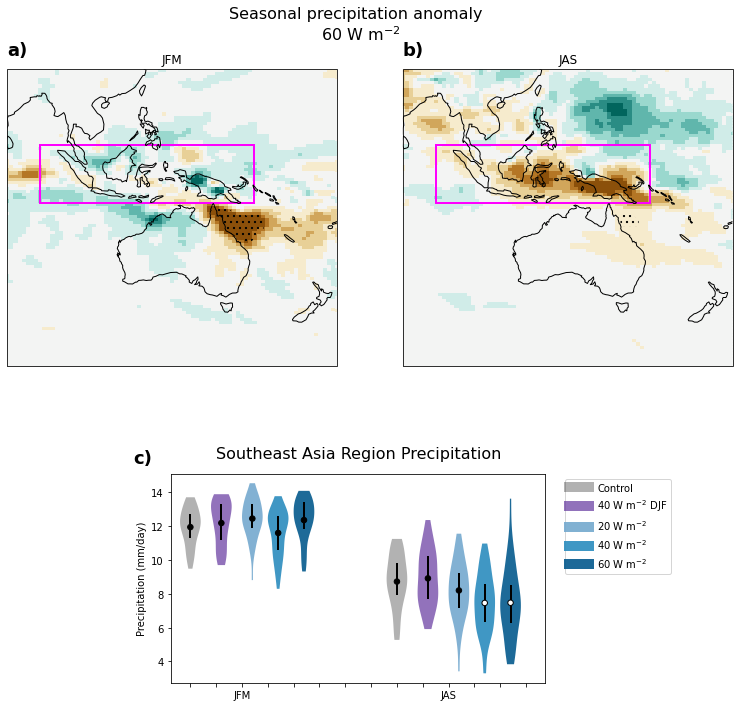

In [25]:
sea_bounds = GeographicBounds(90,155,-10.5,7)

# Create the main figure
fig = plt.figure(figsize=(13, 10))

# Create two subfigures side by side
topfig, bottomfig = fig.subfigures(2, 1, height_ratios=(1.6,1))

top_left_axs = topfig.add_subplot(121, projection=ccrs.PlateCarree())
top_right_axs = topfig.add_subplot(122, projection=ccrs.PlateCarree())

bottom_axs = bottomfig.add_subplot(111)

topfig.suptitle('Seasonal precipitation anomaly \n 60 W m$^{-2}$', fontsize=16)


plot_seasonal_diffs_with_ttest('derecho-som-anom-eez-60-all','derecho-som-control-qdpnoise1_2_3-all','PRECT',vmin=-1,vmax=1,standardize=False,lev=False,
                               highlight_domain=sea_bounds,months='JFM', axs=[top_left_axs, top_right_axs], domain='gbr')
top_left_axs.set_title("JFM")
top_right_axs.set_title("JAS")


bottomfig.subplots_adjust(left=0.3, right=0.7)
seasonal_var_plot_legend('PRECT', sea_bounds,'land', plot_seasons=['JFM','JAS'], ax=bottom_axs)

bottomfig.suptitle("Southeast Asia Region Precipitation", fontsize=16)


letter_annotation(top_left_axs, 0, 1.05, 'a)')
letter_annotation(top_right_axs, 0, 1.05, 'b)')
letter_annotation(bottom_axs,-0.1, 1.05, 'c)')

fig.savefig('/glade/u/home/wkrantz/new_MCB_teleconnections/figures/pub_figures/figure3.png', dpi=400, bbox_inches='tight')


## Figure 4

In [26]:
# trying to plot stderr insted of min and max
def annual_var_plot(var, bounds,ax, lmask=None,
                    adjust_for_autocorrelation=True):
    namedict= {'PRECT':'P','TS':'TS','SST':'SST','T':'T','PS':'PS','FLUT':'OLR','Z3':'Z','U':'U','V':'V','OMEGA':'$\omega$','SF':'Streamfunction'}
    labeldict={'PRECT':'mm/day','TS':'$^{\circ}$C','T':'$^{\circ}$C','SST':'$^{\circ}$C',
              'PS':'hPa','FLUT':'W/m$^2$','Z3':'m','U':'m/s','V':'m/s','OMEGA':'Pa/s','SF':'$10^6$m$^2$s$^{-1}$'}
    season_dict = {'JFM':1,'AMJ':4,'JAS':7,'OND':10}
    
    pert_data_20= load_seasonal_data('derecho-som-anom-eez-20-all',var)
    pert_data_40= load_seasonal_data('derecho-som-anom-eez-40-all',var)
    #pert_data_40= load_seasonal_data('derecho-som-anom-eez-40-allplus',var)
    pert_data_60= load_seasonal_data('derecho-som-anom-eez-60-all',var)
    pert_data_40DJF = load_seasonal_data('derecho-som-anom-eez-40DJF-all',var)
    #control_data = load_seasonal_data('derecho-som-control-qdpnoise1_2_control-all',var)
    control_data = load_seasonal_data('derecho-som-control-qdpnoise1_2_3-all',var)

    landmask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(control_data.lon,control_data.lat,wrap_lon=True)

    vals=[]
    datasets = [ control_data, pert_data_40DJF,pert_data_20, pert_data_40, pert_data_60]
    #impacts_df = pd.Dataframe()

    for  ds in  datasets:
        months = ds.groupby('time.year').mean()
        if var=='PRECT':
            months = months*86400*1000
        elif var=='SST':
            months = months-273.15
        elif var=='TS':
            months = months-273.15

        if lmask=='land':
            months = months.where(landmask==0, drop=True)
        elif lmask=='ocean':
            months = months.where(landmask!=0, drop=True)
                

            
        if bounds== 'gbr':
            roi = (months * gbr_mask).mean(['lat','lon'])
        else:
            roi = months.sel(lat=slice(bounds.latMin,bounds.latMax), lon=slice(bounds.lonMin,bounds.lonMax)).mean(['lat','lon'])
        vals.append(roi.values)


    # for each dataset in vals, perform a two-sample ks test to see if the distributions are different from the control simulation 

    ks_test_results = ['k','k','k','k','k']
    t_test_results = ['k','k','k','k','k']

    for i in [1,2,3,4]:
            control_data = vals[0]
            pert_data = vals[i]
            if adjust_for_autocorrelation:
                t_test = ttest_with_ac_adjustment(control_data,pert_data)[1]
            else:
                t_test = stats.ttest_ind(control_data,pert_data)[1]
                
            ks_test = stats.ks_2samp(control_data - np.mean(control_data),pert_data - np.mean(pert_data))[1]

            if t_test<0.05:
                t_test_results[i] = 'w'
            if ks_test<0.05:
                ks_test_results[i] = 'w'


    #purple that goes with '#74a9cf','#2b8cbe','#045a8d' is '#54278f'
    colors = ['k','#64379f','#74a9cf','#2b8cbe','#045a8d']
    alphas = [0.3,0.7,.9,.9,.9]
    gap =0.2
    locs = [1,2+gap,3+2*gap,4+2*gap,5+2*gap]
    
    parts = ax.violinplot(vals,  locs, showmeans=True,widths=.8)

    for i,pc in enumerate(parts['bodies']):
        j  = i%5
        pc.set_facecolor(colors[j])
        pc.set_alpha(alphas[j])
        #pc.set_edgecolor('black')




    for partname in ('cbars','cmins','cmaxes','cmeans'):
        vp = parts[partname]
        vp.set_edgecolor('r')
        vp.set_linewidth(0)
    
    vals = np.array(vals)
    # calculate the standard error for each dataset in vals
    stderrs = np.array([np.std(vals[i],axis=0)/np.sqrt(len(vals[i])) for i in range(len(vals))])
    stdevs = np.array([np.std(vals[i],axis=0) for i in range(len(vals))])
    means = np.array([np.mean(vals[i],axis=0) for i in range(len(vals))])
    # calculate the 25th and 75th percentiles
    quartile1 = [np.percentile(vals[i],25,axis=0) for i in range(len(vals))]
    quartile3 = [np.percentile(vals[i],75,axis=0) for i in range(len(vals))]


    ax.scatter(locs,means, c=t_test_results,s=100, zorder=8, marker='o', linewidths=1, edgecolors='k')
    #ax.vlines(locs,means-stderrs,means+stderrs, color='r', lw=3)
    #ax.vlines(locs,means-stdevs,means+stdevs, color='k', lw=4)
    ax.vlines(locs,quartile1,quartile3, color=ks_test_results, lw=4)

    plt.ylabel(f'{namedict[var]} ({labeldict[var]})')


    #labels = ['40-DJF','Control','20','40','60']
    

    #set_axis_style(ax, labels)
    #rotate the x axis labels
    #plt.xticks(rotation=45)
    
    # no x axis labels
    ax.set_xticks([])


    # add a legend
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color='k', lw=10, alpha=0.3), 
                    Line2D([0], [0], color='#64379f', lw=10, alpha=0.7),
                    Line2D([0], [0], color='#74a9cf', lw=10, alpha=0.9),
                    Line2D([0], [0], color='#2b8cbe', lw=10, alpha=0.9),
                    Line2D([0], [0], color='#045a8d', lw=10, alpha=0.9),]

    # legend box with non-bold text, outside of plot
    ax.legend(custom_lines, ['Control', '40 W m$^{-2}$ DJF', '20 W m$^{-2}$', '40 W m$^{-2}$', '60 W m$^{-2}$'], loc='upper right', prop={'weight': 'normal'}, bbox_to_anchor=(1.8, 1), )

In [27]:
al_bounds = GeographicBounds(190,220,42,54)
sow_bounds = GeographicBounds(120,160,-62,-54)


In [29]:

def plot_annual_diffs_with_ttest(exp_pert,exp_control,var, vmin, vmax,axs, subfig,
                                    standardize=False,lev=False,
                                  domain='gbr',months='JFM',seasons=['JFM'],
                                   num_segments = 11,
                                  highlight_domain=None,):
    
    
    namedict= {'PRECT':'P','TS':'TS','SST':'SST','T':'T','PS':'PS','FLUT':'OLR','Z3':'Z','U':'U','V':'V','OMEGA':'$\omega$','SF':'Streamfunction','TREFHT':'T 2m'}
    labeldict={'PRECT':'mm/day','TS':'$^{\circ}$C','T':'$^{\circ}$C','SST':'$^{\circ}$C','TREFHT':'$^{\circ}$C',
              'PS':'hPa','FLUT':'W m$^{-2}$','Z3':'m','U':'m/s','V':'m/s','OMEGA':'Pa/s','SF':'$10^6$m$^2$s$^{-1}$'}
    
    levdict = {'14':'200 hPa','20':'500 hPa','25':'850 hPa'}
    grey = '#908085'

    
    pert_data = load_seasonal_data(exp_pert,var,months=months)
    control_data = load_seasonal_data(exp_control,var,months=months)

    cmap = custom_PiYG
    
    if lev:
        pert_data=pert_data.isel(lev=lev)
        control_data=control_data.isel(lev=lev)
    
    if var=='PRECT':
        pert_data = pert_data*24*24*60*1000
        control_data = control_data*24*24*60*1000
        cmap = custom_BrBG
        
    if var=='PS':
        pert_data = pert_data/100
        control_data=control_data/100
        cmap = custom_PuOr

    if var=='SF':
        pert_data = pert_data * 1e-6
        control_data = control_data * 1e-6
        cmap = custom_PuOr

    if var=='FLUT':
        cmap = custom_PuOr

    if var=='Z3':
        cmap = custom_PiYG

    if var=='SST':
        cmap = custom_RdBu
    if var=='TREFHT':
        cmap = custom_RdBu
    if var=='TS':
        cmap = custom_RdBu
        

    cmap = discrete_colormap(cmap, n_colors=num_segments)
    


    if months=='DJF':
        season_dict = {'DJF':12,'MAM':3,'JJA':6,'SON':9}
    elif months=='JFM':
        season_dict = {'Annual':1}
        
    seas_avg_diffs = []
    seas_sigmasks = []


    months_pert = pert_data.resample(time='1AS').mean(dim='time')
    months_control = control_data.resample(time='1AS').mean(dim='time')

    #tstat,pval = stats.ttest_ind(months_pert, months_control,equal_var=True)
    #p_fdr=p
    pval,p_fdr = ttest_with_fdr(months_pert, months_control)

    seas_avg_diff = (months_pert.mean(dim='time')- months_control.mean(dim='time'))
    if standardize:
        seas_avg_diff = seas_avg_diff/months_control.std(dim='time')

        
    pval_xr = xr.DataArray(pval, dims=seas_avg_diff.dims, coords=seas_avg_diff.coords)

    diff_sigmask = pval_xr.where(pval<=p_fdr)
    # pre-process the data to just zeros and ones
    diff_sigmask = diff_sigmask.fillna(0)
    diff_sigmask = xr.where(diff_sigmask > 0, 1, 0)
    
    seas_avg_diffs.append(seas_avg_diff)
    seas_sigmasks.append(diff_sigmask)







    
        
    #fig = plt.figure(figsize=(15,8))
    fig = subfig
    if domain =='global':
        figwidth=21
    elif domain=='gbr':
        figwidth=13
    else:
        figwidth=13
    # fig = plt.figure(figsize=(10,9), facecolor='white')
    proj = ccrs.PlateCarree(180)
    for i,season in enumerate(season_dict):
        ax = axs[i]
        #ax=plt.subplot(1,1,i+1,projection=proj)
        fill = seas_avg_diffs[i].plot(ax=ax,cmap=cmap,vmin=vmin,vmax=vmax,transform=ccrs.PlateCarree(),add_colorbar=False)
        cs = seas_sigmasks[i].plot.contourf(levels=[0.8,1.0],hatches=['','..'],colors='none',add_colorbar=False,transform=ccrs.PlateCarree(), ax=ax)#levels=[0,1],hatches=['xxx',''],alpha=.2)
        for i, collection in enumerate(cs.collections):
            collection.set_edgecolor('k')
            collection.set_linewidth(0)

        # fill in the land area with white
        if var == 'SST':
            ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='k', facecolor='white'))
        ax.coastlines()
        if domain=='global':
            pass
        elif domain == 'mostly_global':
            ax.set_extent((120,-90,-80,70), crs=proj)
        elif domain == 'gbr':
            #bounds = GeographicBounds(120,180,-50,10)
            bounds = GeographicBounds(-100,0,-60,30)
            ax.set_extent((bounds.lonMin, bounds.lonMax, bounds.latMin, bounds.latMax), crs=proj)
        else:
            bounds = domain
            ax.set_extent((bounds.lonMin, bounds.lonMax, bounds.latMin, bounds.latMax), crs=ccrs.PlateCarree())
        if highlight_domain:
            for domain in highlight_domain:
                #draw a rectangle around the specified geographic domain
                ax.add_patch(plt.Rectangle((domain.lonMin, domain.latMin),
                                           domain.lonMax-domain.lonMin,
                                           domain.latMax-domain.latMin,
                                           fill=None, lw=2, color='magenta',transform=ccrs.PlateCarree()))

        # shpfl = shpreader.Reader('/glade/u/home/wkrantz/new_MCB_teleconnections/scenario-setup/gbr_shapefiles/Great_Barrier_Reef_Marine_Park_Boundary.geojson')
        # for rec, geo in zip(shpfl.records(), shpfl.geometries()):
        #         ax.add_geometries([geo],
        #                         crs=ccrs.PlateCarree(),
        #                         facecolor='none',
        #                         edgecolor='magenta',
        #                         linewidth=1,
        #                         linestyle='--')

        # shpfl = shpreader.Reader('/glade/u/home/wkrantz/new_MCB_teleconnections/scenario-setup/gbr_shapefiles/3dgbr_geomorph/qld_gbrwha_cscz.shp')
        # for rec, geo in zip(shpfl.records(), shpfl.geometries()):
        #         ax.add_geometries([geo],
        #                         crs=ccrs.PlateCarree(),
        #                         facecolor='none',
        #                         edgecolor='magenta',
        #                         linewidth=2,
        #                         linestyle='-')
            
        #ax.gridlines(draw_labels=True)
        #plt.colorbar(fill, orientation='horizontal')

        # plt.title(season)
               
    #### COLORBAR #####

    fig.subplots_adjust(bottom=0.1)
    cbar_ax = fig.add_axes([0.15, 0.04, 0.7, 0.03])
    if standardize:
        label_units = "$\sigma$"
    else:
        label_units = labeldict[var]
    
    cbar = fig.colorbar(fill, cax=cbar_ax, label=label_units, extend='both', orientation='horizontal')

    ticks = np.linspace(vmin, vmax, int(num_segments + 1 ))
    cbar.set_ticks(ticks)

    # Define the labels for the colorbar
    labels = [f'{tick:.1f}' for tick in ticks]
    cbar.set_ticklabels(labels)



    
    title = '$\Delta$' + namedict[var]
    if standardize:
        title = title + "/$\sigma$" + namedict[var]
        
    if lev:
        title = title + ' ' +levdict[str(lev)]


    if '40' in exp_pert:
        forcing_str = '40 W m$^{-2}$'
        if 'DJF' in exp_pert:
            forcing_str = forcing_str + ' DJF'
    elif '20' in exp_pert:
        forcing_str = '20 W m$^{-2}$'
    elif '20' in exp_pert:
        forcing_str = '20 W m$^{-2}$'
    elif '60' in exp_pert:
        forcing_str = '60 W m$^{-2}$'

    title = title + ' - ' + forcing_str

    # make super title for the whole plot
    plt.suptitle(title)
    
    #plt.tight_layout()
    if standardize:
        std_str = 'std'
    else:
        std_str = ''
    saveloc = f'/glade/u/home/wkrantz/new_MCB_teleconnections/analysis/figures/seas_diff_{exp_pert}_{exp_control}_{var}_{domain}_{std_str}'

    #plt.savefig(saveloc+'.png',dpi=400,bbox_inches='tight')
    #plt.show()
    
    del pert_data
    del control_data
    del months_control
    del months_pert

In [ ]:
title_fontfize = 14

# Create the main figure
fig = plt.figure(figsize=(13,7))

# Create two subfigures side by side
leftfig, rightfig = fig.subfigures(1, 2, width_ratios=(3,2))

# Set background color and titles for the subfigures
leftfig.set_facecolor('#ffffff')
leftfig.suptitle('Annual SST anomaly \n 60 W m$^{-2}$ forcing', fontsize= title_fontfize, y=0.96)

rightfig.set_facecolor('#ffffff')
topright, bottomright = rightfig.subfigures(2, 1, height_ratios=(1, 1))
topright.suptitle('Annual N. Pacific Region SST', fontsize= title_fontfize)
bottomright.suptitle('Annual Southern Ocean Region SST', fontsize= title_fontfize)

# Create geographic axes for the left figure (use PlateCarree projection)
left_axs = leftfig.add_subplot(111, projection=ccrs.PlateCarree(180))

# Create standard axes for the right subfigures
# make the top right axis narrower
topright_axs = topright.subplots(1, 1)

bottomright_axs = bottomright.subplots(1, 1)

# # Example plot functions (Assuming they are defined elsewhere)
# # Plotting monthly cycle in bottomright_axs

# Plotting a seasonal difference map in left_axs with the specified projection
letter_annotation(left_axs, 0, 1.05, 'a)')
#add a title to the left axis
#left_axs.set_title('Summer (JFM) SST anomaly \n 40 W m$^{-2}$ forcing', fontsize= title_fontfize)
plot_annual_diffs_with_ttest('derecho-som-anom-eez-60-all','derecho-som-control-qdpnoise1_2_control-all','SST',vmin=-1,vmax=1,standardize=False,lev=False,
                               highlight_domain=[al_bounds,sow_bounds], months='JFM', domain='mostly_global', axs=[left_axs], subfig = leftfig,
                               )



letter_annotation(topright_axs,-0.2, 1.05, 'b)')

annual_var_plot('SST', al_bounds, ax = topright_axs)


letter_annotation(bottomright_axs, -0.2,1.05, 'c)')

annual_var_plot('SST', sow_bounds, ax = bottomright_axs)



# Spacing between the subfigures
topright.subplots_adjust(hspace=0.8, wspace=0.4, left=0.1, right=0.6)

bottomright.subplots_adjust(hspace=0.8, wspace=0.4, left=0.1, right=0.6)

fig.savefig('/glade/u/home/wkrantz/new_MCB_teleconnections/figures/pub_figures/figure4.png', dpi=400, bbox_inches='tight')

plt.show()
